<a href="https://colab.research.google.com/github/devansurf/OnePixelAttacks/blob/main/OnePixelAttack_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Pixel Attack Notebook
The focus of this notebook is to visually explore the One Pixel Attack using different pretrained models.

- Custom CNN trained on 23 Ocean-related Classes -- 50% Accuracy
- Resnet50

In [12]:
%pip install datasets
%pip install torchattacks

In [13]:
#Configuration
class Config:
    batch_size = 12

In [14]:
import torch
import torch.nn as nn
import torchattacks
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image
from torchvision.datasets import CIFAR10
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Predict using Resnet-50

In [15]:
dataset = load_dataset("huggingface/cats-image")
cat_image = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = processor(cat_image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for huggingface/cats-image contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/huggingface/cats-image
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tiger cat


# Adversarial One Pixel Attack

Create test datasets to compare on.

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the dataset
test_dataset = load_dataset('Maysee/tiny-imagenet', split='valid')

# Apply the transformations using the map function
class CustomImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Fetch the Hugging Face dataset item
        item = self.hf_dataset[idx]
        image = item['image'].convert('RGB')  # Ensure image is RGB

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        # Fetch the label
        label = item['label']

        return image, label

# Initialize the custom dataset with transformations
transformed_dataset = CustomImageDataset(test_dataset, transform=transform)

# Create a DataLoader
test_loader = DataLoader(transformed_dataset, batch_size=Config.batch_size, shuffle=True)

Helper functions

In [17]:
class AdversarialWrapper(nn.Module):
    def __init__(self, model):
        super(AdversarialWrapper, self).__init__()
        self.model = model

    def forward(self, images):
        # Adjust the following line to match how your model should be called,
        # and ensure it returns just the logits or predictions as a tensor.
        outputs = self.model(images)
        # Assuming the outputs is an object, extract the logits part.
        # This might need adjustment based on the actual structure of outputs.
        logits = outputs.logits
        return logits

In [18]:
def tensor_to_numpy(image_tensor):
    # Convert to NumPy array
    np_image = image_tensor.cpu().detach().numpy()
    np_image = np.transpose(np_image, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    # Correct denormalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = std * np_image + mean  # Adjust this line to match your normalization
    np_image = np.clip(np_image, 0, 1)  # Ensure values are within [0, 1]
    return np_image


In [19]:
def to_numpy(x):
    return x.detach().cpu().numpy()

In [20]:
def generate_confusion_matrix(actual_labels, predicted_labels):
    cm = confusion_matrix(actual_labels, predicted_labels)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="g")
    ax.set_xlabel("Predicted", fontsize=20)
    ax.xaxis.set_label_position("bottom")
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel("True", fontsize=20)
    plt.yticks(rotation=0)

    plt.title("Refined Confusion Matrix", fontsize=20)

    plt.show()

    F1_score = f1_score(actual_labels, predicted_labels, average='macro')

    print(f'f1_score: {F1_score}')

Proceed to do Adversarial attack (One Pixel attack)

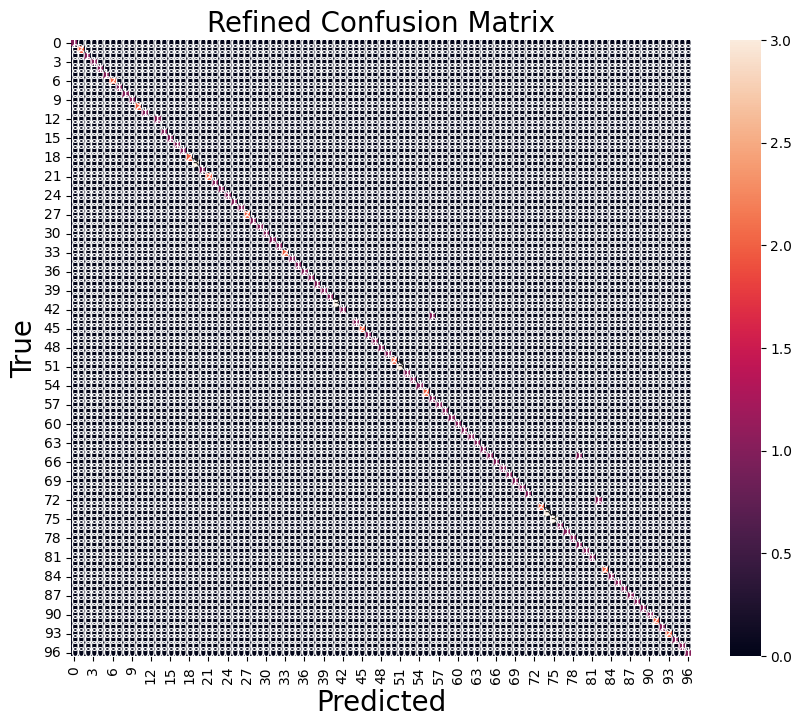

f1_score: 0.9381443298969072


In [21]:
# Prepare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adversarial_model = AdversarialWrapper(model).to(device)
atk = torchattacks.OnePixel(adversarial_model, pixels=1, steps=10, popsize=10, inf_batch=128)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

adversarial_images = []
unaltered_images = []
actual_labels = []
predicted_labels = []

iterations = 10
i = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)



    # Perform the attack
    with torch.no_grad():
        unaltered_images = images
        adversarial_images = atk(images, labels)

        unaltered_logits = model(unaltered_images).logits
        adversarial_logits = model(adversarial_images).logits

    # Convert labels and predictions to CPU and numpy for confusion matrix calculation
    actual_labels.extend(torch.argmax(unaltered_logits, dim=1).cpu().numpy())
    predicted_labels.extend(torch.argmax(adversarial_logits, dim=1).cpu().numpy())
    i += 1
    if i == iterations:
        break  # Remove this to process the entire dataset


generate_confusion_matrix(actual_labels, predicted_labels)



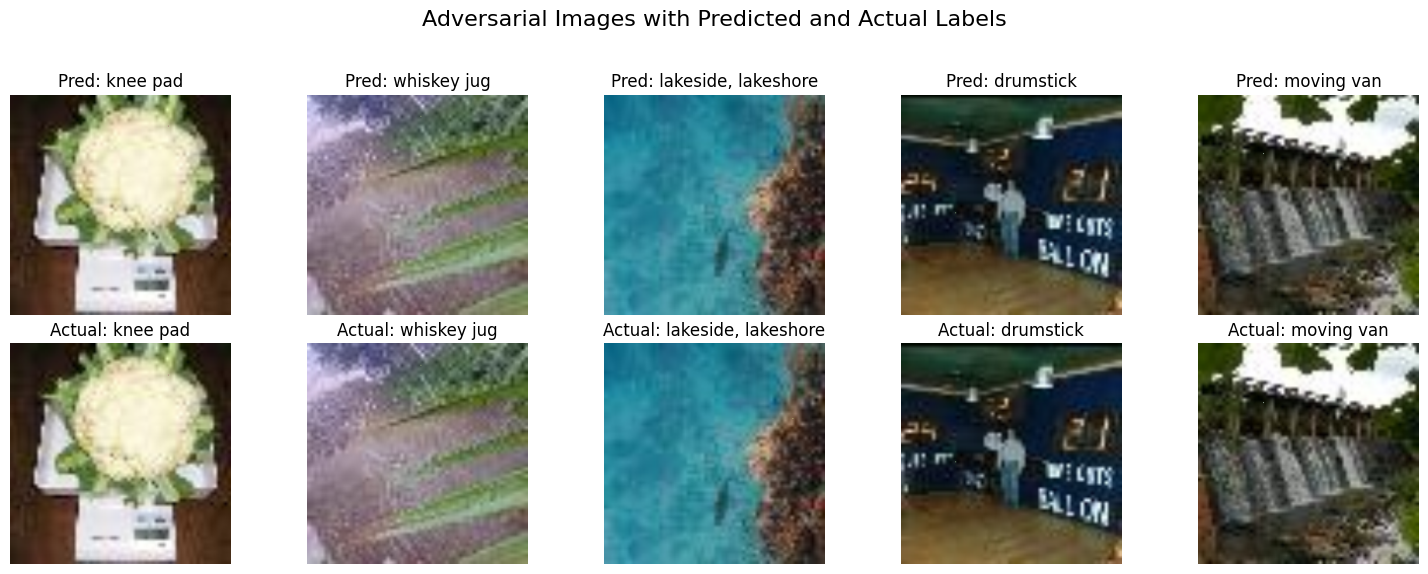

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle('Adversarial Images with Predicted and Actual Labels', fontsize=16)
for i, (img, pred, actual) in enumerate(zip(adversarial_images[:5], predicted_labels[:5], actual_labels[:5])):
    img_np = tensor_to_numpy(img)
    axs[0, i].imshow(img_np)
    axs[0, i].set_title(f'Pred: {model.config.id2label[pred]}')
    axs[0, i].axis('off')

    axs[1, i].imshow(img_np)  # Showing the same image for layout purposes
    axs[1, i].set_title(f'Actual: {model.config.id2label[actual]}')
    axs[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()